# Projeto de Implementação 3

**Aluno:** Igor Carvalho da Silva  
**Matrícula:** 21951288 

**Aluno:** Glenn de Aguiar Oliveira da Fonseca  
**Matrícula:** 21953825

## Dependências

In [1]:
!pip3 install pandas
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 9.0 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=4aaa6a2b1fb41a09e359ab97432afb7427ffd590bf3a9c7ac2ce51183d63f37e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pyspark import *
from pyspark.sql import *
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import HashingTF
from pyspark.ml.feature import IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import monotonically_increasing_id,filter as filter_spark, size

In [3]:
spark = SparkSession.builder.appName('pi3-exec1').getOrCreate()
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

## Dataset Experimental

### Download

In [4]:
!wget https://raw.githubusercontent.com/igroks/bd2/main/projeto-de-implementacao-3/train.csv

--2023-02-02 01:42:24--  https://raw.githubusercontent.com/igroks/bd2/main/projeto-de-implementacao-3/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   2.96M  --.-KB/s    in 0.04s   

2023-02-02 01:42:24 (74.3 MB/s) - ‘train.csv’ saved [3103165/3103165]



### Leitura

In [5]:
# Ler o dataset de treino
rawdata = spark.read.load('train.csv', format='csv', header=True)
rawdata.show()

+---+-----+--------------------+
| id|label|               tweet|
+---+-----+--------------------+
|  1|    0| @user when a fat...|
|  2|    0|@user @user thank...|
|  3|    0|  bihday your maj...|
|  4|    0|#model   i love u...|
|  5|    0| factsguide: soci...|
|  6|    0|[2/2] huge fan fa...|
|  7|    0| @user camping to...|
|  8|    0|the next school y...|
|  9|    0|we won!!! love th...|
| 10|    0| @user @user welc...|
| 11|    0| â #ireland con...|
| 12|    0|we are so selfish...|
| 13|    0|i get to see my d...|
| 14|    1|@user #cnn calls ...|
| 15|    1|no comment!  in #...|
| 16|    0|ouch...junior is ...|
| 17|    0|i am thankful for...|
| 18|    1|retweet if you ag...|
| 19|    0|its #friday! ð...|
| 20|    0|as we all know, e...|
+---+-----+--------------------+
only showing top 20 rows



### Tokenizer e Tratamentos

In [6]:
# Substituir tweets com valor null por string vazia
rawdata = rawdata.fillna({'tweet':''})

# withColumn: adiciona nova coluna uid no DataFrame train_dataset. Conteudo é um contador incremental
rawdata = rawdata.withColumn('uid', monotonically_increasing_id())

tweets = rawdata.select('uid','tweet', 'label')
tweets.show()

+---+--------------------+-----+
|uid|               tweet|label|
+---+--------------------+-----+
|  0| @user when a fat...|    0|
|  1|@user @user thank...|    0|
|  2|  bihday your maj...|    0|
|  3|#model   i love u...|    0|
|  4| factsguide: soci...|    0|
|  5|[2/2] huge fan fa...|    0|
|  6| @user camping to...|    0|
|  7|the next school y...|    0|
|  8|we won!!! love th...|    0|
|  9| @user @user welc...|    0|
| 10| â #ireland con...|    0|
| 11|we are so selfish...|    0|
| 12|i get to see my d...|    0|
| 13|@user #cnn calls ...|    1|
| 14|no comment!  in #...|    1|
| 15|ouch...junior is ...|    0|
| 16|i am thankful for...|    0|
| 17|retweet if you ag...|    1|
| 18|its #friday! ð...|    0|
| 19|as we all know, e...|    0|
+---+--------------------+-----+
only showing top 20 rows



In [7]:
# Cria um extrator de termos ou Tokenizer que lê de inputCol e escreve o resultado em outputCol
# Em seguida executa o tokenizer sobre o dataframe "train_dataset" e escreve o resultado no mesmo
tokenizer = Tokenizer(inputCol='tweet', outputCol='tokens')
tweets = tokenizer.transform(tweets)

In [8]:
tweets.show()

+---+--------------------+-----+--------------------+
|uid|               tweet|label|              tokens|
+---+--------------------+-----+--------------------+
|  0| @user when a fat...|    0|[, @user, when, a...|
|  1|@user @user thank...|    0|[@user, @user, th...|
|  2|  bihday your maj...|    0|[, , bihday, your...|
|  3|#model   i love u...|    0|[#model, , , i, l...|
|  4| factsguide: soci...|    0|[, factsguide:, s...|
|  5|[2/2] huge fan fa...|    0|[[2/2], huge, fan...|
|  6| @user camping to...|    0|[, @user, camping...|
|  7|the next school y...|    0|[the, next, schoo...|
|  8|we won!!! love th...|    0|[we, won!!!, love...|
|  9| @user @user welc...|    0|[, @user, @user, ...|
| 10| â #ireland con...|    0|[, â, #ireland,...|
| 11|we are so selfish...|    0|[we, are, so, sel...|
| 12|i get to see my d...|    0|[i, get, to, see,...|
| 13|@user #cnn calls ...|    1|[@user, #cnn, cal...|
| 14|no comment!  in #...|    1|[no, comment!, , ...|
| 15|ouch...junior is ...|  

In [9]:
tweets = tweets.toPandas()
tweets['tokens'] = tweets['tokens'].apply(lambda x: list(filter(lambda y: y != '', x)))

In [10]:
tweets = spark.createDataFrame(tweets)
tweets.show()

+---+--------------------+-----+--------------------+
|uid|               tweet|label|              tokens|
+---+--------------------+-----+--------------------+
|  0| @user when a fat...|    0|[@user, when, a, ...|
|  1|@user @user thank...|    0|[@user, @user, th...|
|  2|  bihday your maj...|    0|[bihday, your, ma...|
|  3|#model   i love u...|    0|[#model, i, love,...|
|  4| factsguide: soci...|    0|[factsguide:, soc...|
|  5|[2/2] huge fan fa...|    0|[[2/2], huge, fan...|
|  6| @user camping to...|    0|[@user, camping, ...|
|  7|the next school y...|    0|[the, next, schoo...|
|  8|we won!!! love th...|    0|[we, won!!!, love...|
|  9| @user @user welc...|    0|[@user, @user, we...|
| 10| â #ireland con...|    0|[â, #ireland, c...|
| 11|we are so selfish...|    0|[we, are, so, sel...|
| 12|i get to see my d...|    0|[i, get, to, see,...|
| 13|@user #cnn calls ...|    1|[@user, #cnn, cal...|
| 14|no comment!  in #...|    1|[no, comment!, in...|
| 15|ouch...junior is ...|  

### Separar versões

In [11]:
tweets_v1 = tweets
tweets_v1 = tweets_v1.withColumn('tokens', filter_spark('tokens', lambda x: ~x.contains('#')))
tweets_v1 = tweets_v1.where(size(tweets_v1.tokens) != 0) # Remover linhas que tem tokens vazios
tweets_v1.show()

+---+--------------------+-----+--------------------+
|uid|               tweet|label|              tokens|
+---+--------------------+-----+--------------------+
|  0| @user when a fat...|    0|[@user, when, a, ...|
|  1|@user @user thank...|    0|[@user, @user, th...|
|  2|  bihday your maj...|    0|[bihday, your, ma...|
|  3|#model   i love u...|    0|[i, love, u, take...|
|  4| factsguide: soci...|    0|[factsguide:, soc...|
|  5|[2/2] huge fan fa...|    0|[[2/2], huge, fan...|
|  6| @user camping to...|    0|[@user, camping, ...|
|  7|the next school y...|    0|[the, next, schoo...|
|  8|we won!!! love th...|    0|[we, won!!!, love...|
|  9| @user @user welc...|    0|[@user, @user, we...|
| 10| â #ireland con...|    0|[â, consumer, p...|
| 11|we are so selfish...|    0|[we, are, so, sel...|
| 12|i get to see my d...|    0|[i, get, to, see,...|
| 13|@user #cnn calls ...|    1|[@user, calls, mi...|
| 14|no comment!  in #...|    1|  [no, comment!, in]|
| 15|ouch...junior is ...|  

In [12]:
tweets_v2 = tweets
tweets_v2 = tweets_v2.withColumn('tokens', filter_spark('tokens', lambda x: x.contains('#')))
tweets_v2 = tweets_v2.where(size(tweets_v2.tokens) != 0) # Remover linhas que tem tokens vazios
tweets_v2.show()

+---+--------------------+-----+--------------------+
|uid|               tweet|label|              tokens|
+---+--------------------+-----+--------------------+
|  0| @user when a fat...|    0|              [#run]|
|  1|@user @user thank...|    0|[#lyft, #disapoin...|
|  3|#model   i love u...|    0|            [#model]|
|  4| factsguide: soci...|    0|       [#motivation]|
|  5|[2/2] huge fan fa...|    0|   [#allshowandnogo]|
|  7|the next school y...|    0|[#school, #exams,...|
|  8|we won!!! love th...|    0|[#allin, #cavs, #...|
|  9| @user @user welc...|    0|              [#gr8]|
| 10| â #ireland con...|    0|[#ireland, #blog,...|
| 11|we are so selfish...|    0|[#orlando, #stand...|
| 12|i get to see my d...|    0|[#80days, #gettin...|
| 13|@user #cnn calls ...|    1|[#cnn, #michigan,...|
| 14|no comment!  in #...|    1|[#australia, #opk...|
| 15|ouch...junior is ...|    0|[angryð#got7, ...|
| 16|i am thankful for...|    0|[#thankful, #posi...|
| 18|its #friday! ð...|  

In [13]:
tweets_v3 = tweets
tweets_v3.show()

+---+--------------------+-----+--------------------+
|uid|               tweet|label|              tokens|
+---+--------------------+-----+--------------------+
|  0| @user when a fat...|    0|[@user, when, a, ...|
|  1|@user @user thank...|    0|[@user, @user, th...|
|  2|  bihday your maj...|    0|[bihday, your, ma...|
|  3|#model   i love u...|    0|[#model, i, love,...|
|  4| factsguide: soci...|    0|[factsguide:, soc...|
|  5|[2/2] huge fan fa...|    0|[[2/2], huge, fan...|
|  6| @user camping to...|    0|[@user, camping, ...|
|  7|the next school y...|    0|[the, next, schoo...|
|  8|we won!!! love th...|    0|[we, won!!!, love...|
|  9| @user @user welc...|    0|[@user, @user, we...|
| 10| â #ireland con...|    0|[â, #ireland, c...|
| 11|we are so selfish...|    0|[we, are, so, sel...|
| 12|i get to see my d...|    0|[i, get, to, see,...|
| 13|@user #cnn calls ...|    1|[@user, #cnn, cal...|
| 14|no comment!  in #...|    1|[no, comment!, in...|
| 15|ouch...junior is ...|  

## TF-IDF

In [14]:
hashingTF = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [15]:
feat_tweets_v1 = hashingTF.transform(tweets_v1)
idfModel = idf.fit(feat_tweets_v1)
feat_tweets_v1 = idfModel.transform(feat_tweets_v1)
feat_tweets_v1.limit(5).toPandas()

,uid,tweet,label,tokens,rawFeatures,features
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,"[@user, when, a, father, is, dysfunctional, and, is, so, selfish, he, drags, his, kids, into, his, dysfunction.]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 5.2285409801733955, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.215589179762393, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.166197849599261, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,"[@user, @user, thanks, for, credit, i, can't, use, cause, they, don't, offer, wheelchair, vans, in, pdx.]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.6156004371880934, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,2,bihday your majesty,0,"[bihday, your, majesty]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0,"[i, love, u, take, with, u, all, the, time, in, urð±!!!, ðððð ð¦ð¦ð¦]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [16]:
feat_tweets_v2 = hashingTF.transform(tweets_v2)
idfModel = idf.fit(feat_tweets_v2)
feat_tweets_v2 = idfModel.transform(feat_tweets_v2)
feat_tweets_v2.limit(5).toPandas()

,uid,tweet,label,tokens,rawFeatures,features
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,[#run],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,"[#lyft, #disapointed, #getthanked]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0,[#model],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0619781920846005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,4,factsguide: society now #motivation,0,[#motivation],"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [17]:
feat_tweets_v3 = hashingTF.transform(tweets_v3)
idfModel = idf.fit(feat_tweets_v3)
feat_tweets_v3 = idfModel.transform(feat_tweets_v3)
feat_tweets_v3.limit(5).toPandas()

,uid,tweet,label,tokens,rawFeatures,features
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0,"[@user, when, a, father, is, dysfunctional, and, is, so, selfish, he, drags, his, kids, into, his, dysfunction., #run]","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 5.044458094019535, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.1937887790454162, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.938612259254876, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0,"[@user, @user, thanks, for, #lyft, credit, i, can't, use, cause, they, don't, offer, wheelchair, vans, in, pdx., #disapointed, #getthanked]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.5844892804995365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,2,bihday your majesty,0,"[bihday, your, majesty]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
3,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0,"[#model, i, love, u, take, with, u, all, the, time, in, urð±!!!, ðððð ð¦ð¦ð¦]","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.

## K-Means

In [18]:
# KMeans Clustering 
numIterations = 200
numberClusters = 2
kmeans = KMeans().setMaxIter(numIterations).setK(numberClusters).setSeed(1).setDistanceMeasure('cosine') 

In [19]:
kmeans_model = kmeans.fit(feat_tweets_v1)
predictions_v1 = kmeans_model.transform(feat_tweets_v1)
predictions_v1.select('uid','tweet','prediction').limit(5).toPandas()

,uid,tweet,prediction
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,0
2,2,bihday your majesty,1
3,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,1
4,4,factsguide: society now #motivation,0


In [20]:
kmeans_model = kmeans.fit(feat_tweets_v2)
predictions_v2 = kmeans_model.transform(feat_tweets_v2)
predictions_v2.select('uid','tweet','prediction').limit(5).toPandas()

,uid,tweet,prediction
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,1
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,1
2,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,0
3,4,factsguide: society now #motivation,0
4,5,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo,1


In [21]:
kmeans_model = kmeans.fit(feat_tweets_v3)
predictions_v3 = kmeans_model.transform(feat_tweets_v3)
predictions_v3.select('uid','tweet','prediction').limit(5).toPandas()

,uid,tweet,prediction
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,0
1,1,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,1
2,2,bihday your majesty,0
3,3,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,1
4,4,factsguide: society now #motivation,0


## Métricas

In [22]:
predictions_v1 = predictions_v1.withColumn('prediction', predictions_v1.prediction.cast(DoubleType()))
predictions_v2 = predictions_v2.withColumn('prediction', predictions_v2.prediction.cast(DoubleType()))
predictions_v3 = predictions_v3.withColumn('prediction', predictions_v3.prediction.cast(DoubleType()))

predictions_v1 = predictions_v1.withColumn('label', predictions_v1.label.cast(DoubleType()))
predictions_v2 = predictions_v2.withColumn('label', predictions_v2.label.cast(DoubleType()))
predictions_v3 = predictions_v3.withColumn('label', predictions_v3.label.cast(DoubleType()))

In [23]:
p_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedPrecision")
r_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction",metricName="weightedRecall")

In [28]:
results = []

In [29]:
prec = p_evaluator.evaluate(predictions_v1)
rec = r_evaluator.evaluate(predictions_v1)
results.append((prec, rec))

In [30]:
prec = p_evaluator.evaluate(predictions_v2)
rec = r_evaluator.evaluate(predictions_v2)
results.append((prec, rec))

In [31]:
prec = p_evaluator.evaluate(predictions_v3)
rec = r_evaluator.evaluate(predictions_v3)
results.append((prec, rec))

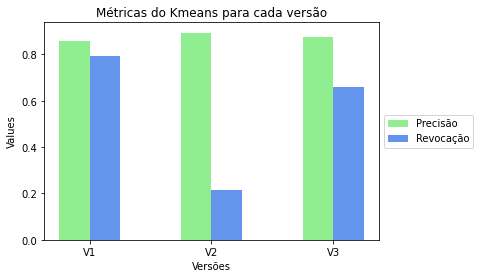

In [37]:
x_labels = ['V1', 'V2', 'V3']
bar_width = 0.25

precs, recs = zip(*results)

r1 = np.array(range(len(precs)))
r2 = [x + bar_width for x in r1]

plt.bar(r1, precs, color='lightgreen', width=bar_width, label='Precisão')
plt.bar(r2, recs, color='cornflowerblue', width=bar_width, label='Revocação')

plt.xlabel('Versões')
plt.xticks([r + bar_width/2 for r in range(len(precs))], x_labels)
plt.ylabel('Values')

plt.title('Métricas do Kmeans para cada versão')  
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()